# SerPyShock simplified notebook

Initial setup and imports

In [1]:
import datetime as dt

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, FormatStrFormatter, MultipleLocator)
from seppy.loader.solo import mag_load
from solo_epd_loader import epd_load

from SerPyShock import SerPyShock
from solo_swa_loader import swa_load_grnd_mom

In [2]:
path = 'data/'  # Directory for the downloaded data in this project
plt.rcParams.update({'font.size': 12})  # increase font size for matplotlib

### Set plotting window

In [3]:
#Set zoomed-in plotting window
start_time = pd.to_datetime('2021-11-03 13:50:00')
end_time = pd.to_datetime('2021-11-03 14:20:00')

### Download magnetic field and plasma data

In [4]:
#DT I am pretty sure that this can be done in a much better way
startdate = dt.date(2021, 11, 2)
enddate = dt.date(2021, 11, 4)
#Download magnetic field data for the zoomed-in interval
df_mag_normal = mag_load(start_time, end_time, level='l2', data_type='normal', frame='rtn', path="./mag")
df_mag_normal["B"] = np.linalg.norm(df_mag_normal[["B_RTN_0","B_RTN_1","B_RTN_2"]],axis=1)
#Download SWA data 
df_swa = swa_load_grnd_mom(startdate, enddate, path=path)
df_swa["V"] = np.linalg.norm(df_swa[["V_RTN_0","V_RTN_1","V_RTN_2"]],axis=1)
df_swa_zoomed = df_swa.loc[(df_swa.index >= start_time) & (df_swa.index <= end_time)]
df_MAG_zoomed = df_mag_normal.loc[(df_mag_normal.index >= start_time) & (df_mag_normal.index <= end_time)]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_l2_mag-rtn-normal_20211103_v01.cdf:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

solo_L2_swa-pas-grnd-mom_20211102_V03.cdf:   0%|          | 0.00/3.34M [00:00<?, ?B/s]

solo_L2_swa-pas-grnd-mom_20211104_V03.cdf:   0%|          | 0.00/3.34M [00:00<?, ?B/s]

solo_L2_swa-pas-grnd-mom_20211103_V03.cdf:   0%|          | 0.00/3.34M [00:00<?, ?B/s]

### Select shock time and set up parameters for SerPyShock estimation
Just for your info, remember that the ipshocks.fi catalogue uses windows of 8 minutes upstream and 8 minutes downstream of the shock, and they exclude 1 minute upstream and 2 minutes downstream of the shock

In [6]:
# Choose shock time
shock_time = pd.to_datetime('2021-11-03 14:04:20')
#Select the largest upstream window 
start_time_up  = shock_time  - dt.timedelta(minutes = 9) # Largest upstream window start time
end_time_up = shock_time  - dt.timedelta(minutes = 1)    # Largest upstream window end time
#Select the largest downstream window 
start_time_down  = shock_time  + dt.timedelta(minutes = 2) # Largest downstream window start time
end_time_down = shock_time  + dt.timedelta(minutes = 10)   # Largest downstream window end time

#Select minimum and maximum durations of the upstream and downstream windows
#for the systematic analysis
min_dur_up = dt.timedelta(minutes=2) # Duration of the smallest upstream window (tiems will span end_time_up - min_dur_up --> end_time_up + min_dur_up)
max_dur_up = end_time_up - start_time_up # Duration of the largest upstream window (do not edit)
min_dur_down =  dt.timedelta(minutes=2) # Duration of the smallest downstream window (time will span start_time_down --> start_time_down + min_dur_down)
max_dur_down = end_time_down - start_time_down # Duration of the largest downstream window (do not edit)
#Select the cadence by which the window lengths are increased (should be larger than the instrument plasma cadence)
cadence =  dt.timedelta(seconds=20)

### Generate overview plot of event with smallest and largest upstream/downstream windows

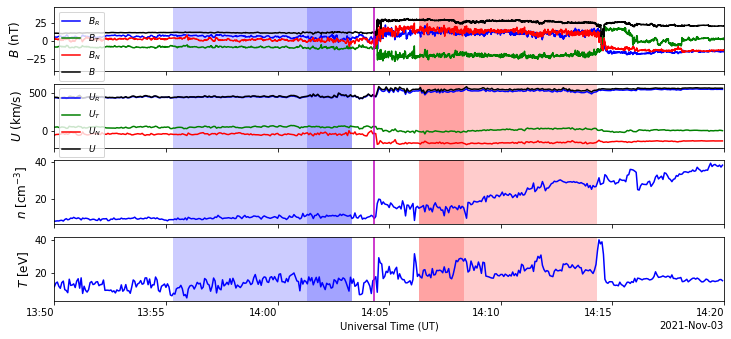

In [7]:
fsax = 12 #fontsize ax 
#Determine the limits of the upstream and downstream windows, smallest and largest
sldu = int(np.floor((max_dur_up-min_dur_up)/cadence)) 
sldd = int(np.floor((max_dur_down-min_dur_down)/cadence))
stut_min = end_time_up - min_dur_up - 0*cadence
stut_max = end_time_up - min_dur_up - sldu*cadence
endt_min = start_time_down + min_dur_down + 0*cadence
endt_max = start_time_down + min_dur_down + sldd*cadence

fig = plt.figure(figsize = (12,6))
gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[0, 0])
df_mag_normal[["B_RTN_0","B_RTN_1","B_RTN_2","B"]].plot(ax=ax1,color=["blue","green","red","black"])
ax1.set_ylabel("$B$ (nT)",fontsize=fsax)
ax1.legend(loc='upper left', fontsize=9,labels=["$B_R$","$B_T$","$B_N$","$B$"])

ax2 = fig.add_subplot(gs[1, 0])
df_swa_zoomed[["V_RTN_0","V_RTN_1","V_RTN_2","V"]].plot(ax=ax2,color=["blue","green","red","black"])
ax2.set_ylabel("$U$ (km/s)", fontsize=fsax)
ax2.legend(loc='upper left', fontsize=9,labels=["$U_R$","$U_T$","$U_N$","$U$"])

ax3 = fig.add_subplot(gs[2, 0])
df_swa_zoomed["N"].plot(ax=ax3,color="b")
ax3.set_ylabel('$n$ [cm$^{-3}$]',fontsize=fsax)

ax4 = fig.add_subplot(gs[3, 0])
df_swa_zoomed["T"].plot(ax=ax4,color="b",rot=0)
ax4.set_ylabel('$T$ [eV]',fontsize=fsax)
ax4.set_xlabel("Universal Time (UT)")
locator = mdates.AutoDateLocator()
ax4.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

for ax in [ax1,ax2,ax3,ax4]:
    ax.axvline(x=shock_time,color='m')
    ax.axvspan(stut_min,end_time_up, facecolor = 'b', alpha = 0.2)
    ax.axvspan(stut_max,end_time_up, facecolor = 'b', alpha = 0.2)
    ax.axvspan(start_time_down,endt_min, facecolor = 'r', alpha = 0.2)
    ax.axvspan(start_time_down,endt_max, facecolor = 'r', alpha = 0.2)
    ax.set_xlim(start_time,end_time)
    if ax!=ax4:
        ax.set_xticklabels('')
        ax.set_xlabel('')
plt.savefig('Nov3_overview.jpg')

In [8]:
#Prepare the input parameters for SerPyShock - no need to edit
B = df_mag_normal[["B_RTN_0","B_RTN_1","B_RTN_2"]].values
B_times = df_mag_normal.index
V = df_swa_zoomed[["V_RTN_0","V_RTN_1","V_RTN_2"]].values
Rho = df_swa_zoomed["N"].values
Tp = df_swa_zoomed["T"].values
mom_times = df_swa_zoomed.index
coord = "RTN"
#B_times

### First SerPyShock run: shock normals and $\theta_{Bn}$, magnetic compression ratios $r_B$
This estimates the set of shock normals and relative $\theta_{Bn}$ with Magnetic Coplanarity and Mixed Mode methods MX1, MX2 and MX3. It builds also a distribution of magnetic compression ratios.

In [9]:
#Run SerPyShock systematic calculations
n, tbn, rB, ex = SerPyShock.MX_stats(B_times, B, mom_times, V, shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence, coord)

Upstream windows = 0 / 18
Upstream windows = 1 / 18
Upstream windows = 2 / 18
Upstream windows = 3 / 18
Upstream windows = 4 / 18
Upstream windows = 5 / 18
Upstream windows = 6 / 18
Upstream windows = 7 / 18
Upstream windows = 8 / 18
Upstream windows = 9 / 18
Upstream windows = 10 / 18
Upstream windows = 11 / 18
Upstream windows = 12 / 18
Upstream windows = 13 / 18
Upstream windows = 14 / 18
Upstream windows = 15 / 18
Upstream windows = 16 / 18
Upstream windows = 17 / 18


### Histogram of $\theta_{Bn}$

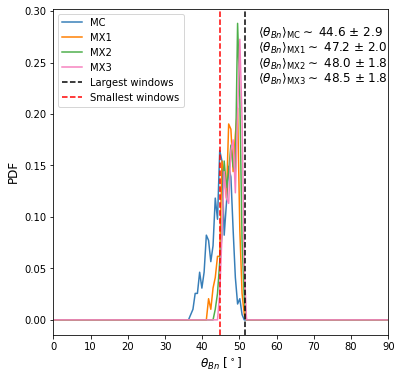

<Figure size 432x288 with 0 Axes>

In [10]:
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
nbns = 150
hist1,bin_edges = np.histogram(tbn.MC, bins = nbns, range=(0,90), density=True)
hist2,bin_edges = np.histogram(tbn.MX1, bins = nbns, range=(0,90), density=True)
hist3,bin_edges = np.histogram(tbn.MX2, bins = nbns, range=(0,90), density=True)
hist4,bin_edges = np.histogram(tbn.MX3, bins = nbns, range=(0,90), density=True)

bin_centers = bin_edges[0:-1] + (bin_edges[1:]-bin_edges[0:-1])/2
fig = plt.figure(figsize = (6,6))
ax5 = fig.add_subplot()
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
ax5.plot(bin_centers,hist1, color = CB[0], label = 'MC')
ax5.plot(bin_centers,hist2, color = CB[1], label = 'MX1')
ax5.plot(bin_centers,hist3, color = CB[2], label = 'MX2')
ax5.plot(bin_centers,hist4, color = CB[3], label = 'MX3')
ax5.axvline(x=ex.tbn_luld,linestyle = '--',color='black', label = 'Largest windows')
ax5.axvline(x=ex.tbn_susd,linestyle = '--',color='red',   label = 'Smallest windows')
ax5.set_xlabel(r'$\theta_{Bn}$ $[^\circ]$',fontsize=fsax)
ax5.set_ylabel(r'PDF',fontsize=fsax)
ax5.legend(fontsize=10, loc='upper left')

values = [tbn.MC,tbn.MX1,tbn.MX2,tbn.MX3]
labels = ["MC","MX1","MX2","MX3"]
i = 0
for value,label in zip(values,labels):
    avg = np.mean(value)
    std = np.std(value)
    st = '$\langle \\theta_{Bn} \\rangle_{\mathrm{%s}} \sim $ %0.1f $\pm $ %0.1f' %(label,avg,std)
    plt.text(55,0.275-i*0.015,st,fontsize=12)
    i += 1

ax5.set_xlim(0,90)

#plt.tight_layout()
plt.show()
plt.savefig('Nov3_tbn.jpg')

### Magnetic compression ratio diagnostic and histogram

(0.0, 6.0)

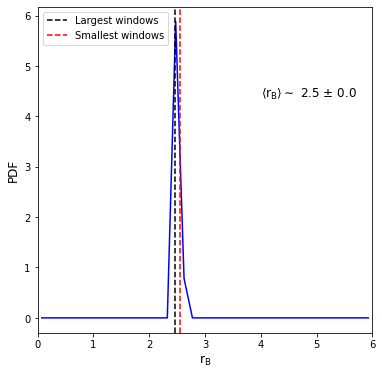

In [11]:
#~~~~~~~~~Edit the following three parameters if you like~~~#
nbns = 40 # Number of bins for the histogram
rbmin = 0 # Minimum compression ratio you want to sample
rbmax = 6 # Maximum compression ratio you want to sample
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


hist_rB,bin_edges = np.histogram(rB, bins = nbns, range=(rbmin,rbmax), density=True)
bin_centers = bin_edges[0:-1] + (bin_edges[1:]-bin_edges[0:-1])/2
fig = plt.figure(figsize = (6,6))
ax5 = fig.add_subplot()
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
ax5.plot(bin_centers,hist_rB, color = 'b')

ax5.axvline(x=ex.rB_luld,linestyle = '--',color='black', label = 'Largest windows')
ax5.axvline(x=ex.rB_susd,linestyle = '--',color='red',   label = 'Smallest windows')
ax5.set_xlabel(r'$\mathrm{r_B}$',fontsize=fsax)
ax5.set_ylabel(r'PDF',fontsize=fsax)
ax5.legend(fontsize=10, loc='upper left')
lbl = "$r_B$"
avg = np.mean(rB)
std = np.std(rB)
st = '$\langle \mathrm{r_B} \\rangle \sim $ %0.1f $\pm $ %0.1f' %(avg,std)
plt.text(rbmax - 2, np.max(hist_rB)-1.5, st,fontsize=12)

ax5.set_xlim(rbmin, rbmax)
#print(np.max(hist_rB))

### Gas compression ratio diagnotic and histogram

In [12]:
rG, ex_rG = SerPyShock.rgas_stats(mom_times, Rho, shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence)

Upstream windows = 0 / 18
Upstream windows = 1 / 18
Upstream windows = 2 / 18
Upstream windows = 3 / 18
Upstream windows = 4 / 18
Upstream windows = 5 / 18
Upstream windows = 6 / 18
Upstream windows = 7 / 18
Upstream windows = 8 / 18
Upstream windows = 9 / 18
Upstream windows = 10 / 18
Upstream windows = 11 / 18
Upstream windows = 12 / 18
Upstream windows = 13 / 18
Upstream windows = 14 / 18
Upstream windows = 15 / 18
Upstream windows = 16 / 18
Upstream windows = 17 / 18


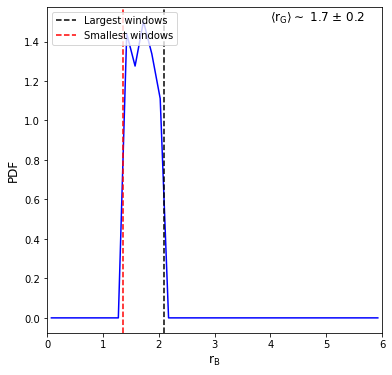

In [13]:
#~~~~~~~~~Edit the following three parameters if you like~~~#
nbns = 40 # Number of bins for the histogram
rgmin = 0 # Minimum compression ratio you want to sample
rgmax = 6 # Maximum compression ratio you want to sample
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


hist_rG,bin_edges = np.histogram(rG, bins = nbns, range=(rgmin,rgmax), density=True)
bin_centers = bin_edges[0:-1] + (bin_edges[1:]-bin_edges[0:-1])/2
fig = plt.figure(figsize = (6,6))
ax5 = fig.add_subplot()
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
ax5.plot(bin_centers,hist_rG, color = 'b')

ax5.axvline(x=ex_rG.r_max,linestyle = '--',color='black', label = 'Largest windows')
ax5.axvline(x=ex_rG.r_min,linestyle = '--',color='red',   label = 'Smallest windows')
ax5.set_xlabel(r'$\mathrm{r_B}$',fontsize=fsax)
ax5.set_ylabel(r'PDF',fontsize=fsax)
ax5.legend(fontsize=10, loc='upper left')
lbl = "$r_B$"
avg = np.mean(rG)
std = np.std(rG)
st = '$\langle \mathrm{r_G} \\rangle \sim $ %0.1f $\pm $ %0.1f' %(avg,std)
plt.text(rbmax - 2, np.max(hist_rG), st,fontsize=12)

ax5.set_xlim(rbmin, rbmax)
#print(np.max(hist_rB))
plt.savefig('Nov3_rG.jpg')

### Display average shock normals

In [14]:
print("Your average shock normals are:")
values = [n.MC,n.MX1,n.MX2,n.MX3]
labels = ["MC","MX1","MX2","MX3"]
i = 0
for value,label in zip(values,labels):
    avg = np.mean(value, axis=0)
    avg = avg/np.linalg.norm(avg) # normalise
    print( label + str(avg))
    i += 1

Your average shock normals are:
MC[ 0.27354014 -0.68716541 -0.67303751]
MX1[ 0.51748273 -0.53344606 -0.66906421]
MX2[ 0.55060478 -0.50615779 -0.66380619]
MX3[ 0.56633344 -0.49259143 -0.66077236]


## Shock speed estimation using mass flux conservation
Run SerPyShock to get a distribution of shock speeds, computed in the spacecraft rest frame and along the shock normal. Here the shock normal is fixed, and we recommend to choose between the average obtained with the previous SerPyShock run using MC, MX12 or MX3 (here defaults to MX3).

In [15]:
n_avg = np.mean(n.MX3, axis=0)
n_avg = n_avg/np.linalg.norm(n_avg)
vsh, exv = SerPyShock.Vsh_stats(n_avg, mom_times, V, Rho, shock_time,end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence)

Upstream windows = 0 / 18
Upstream windows = 1 / 18
Upstream windows = 2 / 18
Upstream windows = 3 / 18
Upstream windows = 4 / 18
Upstream windows = 5 / 18
Upstream windows = 6 / 18
Upstream windows = 7 / 18
Upstream windows = 8 / 18
Upstream windows = 9 / 18
Upstream windows = 10 / 18
Upstream windows = 11 / 18
Upstream windows = 12 / 18
Upstream windows = 13 / 18
Upstream windows = 14 / 18
Upstream windows = 15 / 18
Upstream windows = 16 / 18
Upstream windows = 17 / 18


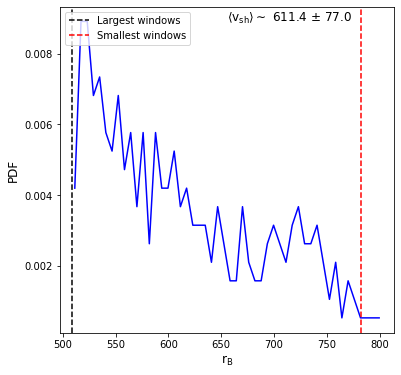

In [16]:
#~~~~~~~~~Edit the following if you like (did not bound this one~~~#
nbns = 50 # Number of bins for the histogram
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
hist_vsh,bin_edges = np.histogram(vsh, bins = nbns, density=True)
bin_centers = bin_edges[0:-1] + (bin_edges[1:]-bin_edges[0:-1])/2
fig = plt.figure(figsize = (6,6))
ax5 = fig.add_subplot()
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
ax5.plot(bin_centers,hist_vsh, color = 'b')

ax5.axvline(x=exv.vshmax,linestyle = '--',color='black', label = 'Largest windows')
ax5.axvline(x=exv.vshmin,linestyle = '--',color='red',   label = 'Smallest windows')
ax5.set_xlabel(r'$\mathrm{r_B}$',fontsize=fsax)
ax5.set_ylabel(r'PDF',fontsize=fsax)
ax5.legend(fontsize=10, loc='upper left')
lbl = "$r_B$"
avg = np.mean(vsh)
std = np.std(vsh)
st = '$\langle \mathrm{v_{sh}} \\rangle \sim $ %0.1f $\pm $ %0.1f' %(avg,std)
plt.text((np.min(bin_centers) +np.max(bin_centers))/2, np.max(hist_vsh), st,fontsize=12)
plt.savefig('Nov3_speed.jpg')
#ax5.set_xlim(rbmin, rbmax)
#print(np.max(hist_rB))

### Estimation of Mach numbers and average upstream properties

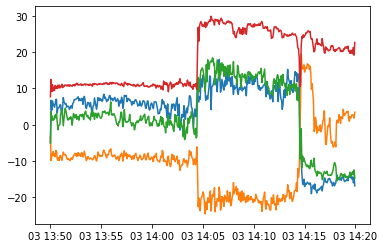

In [20]:
from scipy.signal import resample as resmpl
Bz = df_MAG_zoomed[["B_RTN_0","B_RTN_1","B_RTN_2"]].values
t_Bz = df_MAG_zoomed.index
B.shape
V.shape
Brs = V*0
Brs[:,0] = resmpl(Bz[:,0],V.shape[0])
Brs[:,1] = resmpl(Bz[:,1],V.shape[0])
Brs[:,2] = resmpl(Bz[:,2],V.shape[0])
plt.plot(mom_times,Brs )
plt.plot(mom_times,np.linalg.norm(Brs,axis=1))

### Compute relevant quantities and operate projection in shock rest frame

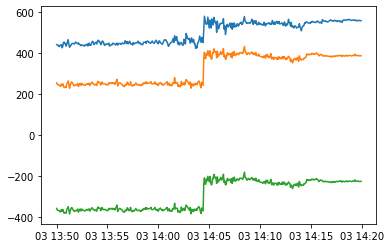

In [21]:
tbn_avg = np.mean(tbn.MX3)
n_avg = np.mean(n.MX3, axis=0)
n_avg = n_avg/np.linalg.norm(n_avg) # normalise
vsh_avg = np.mean(vsh)
# Below a bunch of constants / numbers useful for conversions
mu0   = 1.257e-06;
evtoK = 11604.5250061657;
kB    =  1.38e-23;
nTtoT = 1e-09;
efc   = 1.6e-19;
eps0  = 8.85e-12;
mp    = 1.67e-27;
clight= 2.99e08; 
gam  = 5/3;

# Magnetic field and bulk flow speed magnitude
Bm = np.linalg.norm(Brs, axis = 1)
Um = np.linalg.norm(V, axis = 1)

beta = (2*mu0*kB)*(Tp*evtoK*Rho*10**6)/((Bm*nTtoT)**2); # plasma beta
wp   = np.sqrt(  ((efc*efc)*Rho*10**6)/(eps0*mp)   ); # Plasma frequency
di   = clight/wp; # Ion skin depth
vA   = (Bm*nTtoT)/np.sqrt((mu0*mp)*Rho*10**6); # Alfven speed
cs   = np.sqrt((gam*kB/mp)*Tp*evtoK); # Sound speed
    
VA2 = vA**2;
VS2 = cs**2;
rtt = np.sqrt( (VA2+VS2)**2 - VA2*VS2*(4*np.cos(tbn_avg*np.pi/180)**2));
Vfms = np.sqrt(.5*(VA2+VS2+rtt)); # Fast magnetosonic speed
Vsms = np.sqrt(.5*(VA2+VS2-rtt)); # Slow magnetosonic speed

Un = np.dot(V,n_avg); # Bulk flow speed along shock normal
Un_sf = Un - vsh_avg; # Bulk flow speed in the shock rest frame

# Some test plotting
plt.plot(mom_times, Um)
plt.plot(mom_times, Un)
plt.plot(mom_times, Un_sf)

### Estimate Mach numbers and other mean upstream quantities
#### You can edit these two times to choose how much of the upstream you want to average over. It defaults to the largest upstream window chosen in SerPyShock


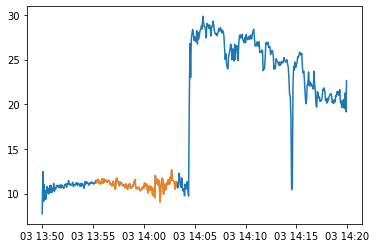

In [22]:
#~~~~~~~~The two below can be edited~~~~#
st_up = start_time_up
en_up = end_time_up
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

Vitsu, Viteu   = SerPyShock.get_time_indices(st_up, en_up, mom_times)
tsv, sVu       = SerPyShock.select_subS(V, mom_times, Vitsu, Viteu, 3)
tsv, sRhou     = SerPyShock.select_subS(Rho, mom_times, Vitsu, Viteu, 1)
tsv, sBu     = SerPyShock.select_subS(Brs, mom_times, Vitsu, Viteu, 3)
tsv, sTpu     = SerPyShock.select_subS(Tp, mom_times, Vitsu, Viteu, 1)
tsv, sBmu     = SerPyShock.select_subS(Bm, mom_times, Vitsu, Viteu, 1)
tsv, sUmu     = SerPyShock.select_subS(Um, mom_times, Vitsu, Viteu, 1)
tsv, sUnu     = SerPyShock.select_subS(Un, mom_times, Vitsu, Viteu, 1)
tsv, sUn_sfu     = SerPyShock.select_subS(Un_sf, mom_times, Vitsu, Viteu, 1)

# PURPOSE: The orange show in which upstream you are averaging
plt.plot(mom_times, Bm)
plt.plot(tsv, sBmu)

In [23]:
print("Below are your fast magnetosonic, slow magnetosonic and Alfvenic Mach numbers")

Mfms = np.nanmean(np.abs(Un_sf[Vitsu:Viteu]))/np.nanmean(Vfms[Vitsu:Viteu]*10**(-3))
Msms = np.nanmean(np.abs(Un_sf[Vitsu:Viteu]))/np.nanmean(Vsms[Vitsu:Viteu]*10**(-3))
Ma   = np.nanmean(np.abs(Un_sf[Vitsu:Viteu]))/np.nanmean(vA[Vitsu:Viteu]*10**(-3))

betau = np.nanmean(np.abs(beta[Vitsu:Viteu]))
rhou  = np.nanmean(np.abs(Rho[Vitsu:Viteu]))

print("M_fms = " + str(Mfms))
print("M_sms = " + str(Msms))
print("M_A = " + str(Ma))

Below are your fast magnetosonic, slow magnetosonic and Alfvenic Mach numbers
M_fms = 4.286554293237446
M_sms = 13.007428722574376
M_A = 4.8249253164897565
